#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)


In [3]:

# metoda, która liczy pojedyńczą entropię czyli ilość wsytąpień / ilość próbek
def entropy_func(class_count, num_samples):
    probability = class_count / num_samples
    return -probability * math.log2(probability)


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return len(self.group_classes)

    # sumuję entropię dla każdej grupy
    def group_entropy(self):
        counter = Counter(self.group_classes)
        return sum(entropy_func(class_count, len(self)) for class_count in counter.values())


class Node:
    def __init__(self, split_feature=None, split_val=None, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    # metoda, która przewiduje klasę dla danego wiersza
    def predict(self, data):
        # jeśli węzeł jest liściem to zwracamy jego wartość (jest liściem tzn, że nie ma dzieci)
        if self.child_node_a is None and self.child_node_b is None:
            return self.val
        # jeśli wartość w wierszu jest mniejsza lub równa od wartości podziału to idziemy do lewego dziecka, a jeśli nie to do prawego
        if data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None

    # metoda, która liczy entropię dla podziału na dwie grupy
    # liczby entropię dla każdej grupy i  mnoży ją przez ilość próbek grupy / ilość wszystkich próbek
    def get_split_entropy(self, group_a, group_b):
        group_a_lenght = len(group_a)
        group_b_lenght = len(group_b)

        total_samples = group_a_lenght + group_b_lenght

        a_entropy = (group_a_lenght / total_samples) * group_a.group_entropy()
        b_entropy = (group_b_lenght / total_samples) * group_b.group_entropy()

        return a_entropy + b_entropy

    # informacja o zysku informacji, polega na odjęciu entropii rodzica od entropii podziału
    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        parent_entropy = parent_group.group_entropy()
        split_entropy = self.get_split_entropy(child_group_a, child_group_b)
        return parent_entropy - split_entropy

    # metoda, która znajduje najlepszy podział dla danej cechy
    def get_best_feature_split(self, feature_values, classes):
        # wybieramy wartości unikalne i je sortujemy
        unique_values = list(set(feature_values))
        unique_values.sort()

        best_split_val = None
        best_info_gain = -1

        # dla każdej wartości unikalnej  twożymy maskę, która zwraca nam wartości true/false
        # jeśli wartość jest mniejsza lub równa od wartości unikalnej to true
        # jeśli wartość jest większa od wartości unikalnej to false
        for val in unique_values:
            mask = feature_values <= val
            group_a = Group(classes[mask])
            group_b = Group(classes[~mask])

            # zwaracamy wartość unikalną i zysk informacji dla takiego podziału
            info_gain = self.get_information_gain(Group(classes), group_a, group_b)

            # jeśli zysk informacji jest większy od najlepszego zysku informacji to zapisujemy go
            # i wartość unikalną jako najlepszą wartość podziału
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_split_val = val

        return best_split_val, best_info_gain

    # metoda, która znajduje najlepszy podział dla wszystkich cech
    def get_best_split(self, data, classes):
        # pobieramy ilość cech
        num_features = data.shape[1]
        best_feature = None
        best_split_val = None
        best_info_gain = -1

        # dla każdej cechy znajdujemy najlepszy podział
        for feature in range(num_features):
            split_val, info_gain = self.get_best_feature_split(data[:, feature], classes)

            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_split_val = split_val
                best_feature = feature

        return best_feature, best_split_val

    # metoda, która buduje drzewo rekurencyjnie
    def build_tree(self, data, classes, depth=0):
        # tworzymy liść jeśli osiągneliśmy maksymalną głębokość lub wszystkie próbki mają tą samą klasę
        unique_classes = len(set(classes))
        if depth == self.max_depth or unique_classes == 1:
            return Node(val=Counter(classes).most_common(1)[0][0])

        # znajdujemy najlepszy podział, a jeśli nie ma to tworzymy liść
        best_feature, best_split_val = self.get_best_split(data, classes)
        if best_feature is None:
            return Node(val=Counter(classes).most_common(1)[0][0])

        # tworzymy dwie grupy na podstawie najlepszego podziału, tworząc maski, które zwracaję te wiersze
        # które spełniają warunek podziału, czyli są mniejsze/równe od podziału lub większe od podziału
        mask = data[:, best_feature] <= best_split_val
        child_node_a = self.build_tree(data[mask], classes[mask], depth + 1)
        child_node_b = self.build_tree(data[~mask], classes[~mask], depth + 1)

        # zwracamy węzeł, który zawiera informacje o podziale i dzieciach
        return Node(split_feature=best_feature, split_val=best_split_val, depth=depth,
                    child_node_a=child_node_a, child_node_b=child_node_b)

    # metoda, która ustawia drzewo
    def start_tree(self, data, classes):
        self.tree = self.build_tree(data, classes)

    # metoda, która przewiduje klasę dla danego wiersza
    def predict(self, data):
        return self.tree.predict(data)

In [23]:
dc = DecisionTreeClassifier(3)
dc.start_tree(x_train, y_train)
for sample, gt in zip(x_test, y_test):
    predicion = dc.predict(sample)
    print(evaluate_accuracy(dc, x_test, y_test))

True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
0.9333333333333333
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Clas

Funckja pomocnicza, do badania dokładnośc
--

In [4]:
# dodatkowa funkcja, która liczy dokładność, na podstawie danych testowych oraz klas
def evaluate_accuracy(dc, test_data, test_classes):
        correct_predictions = 0
        total_samples = len(test_data)

        for data_point, true_class in zip(test_data, test_classes):
            predicted_class = dc.predict(data_point)

            if true_class == predicted_class:
                correct_predictions += 1

            print(f"True Class: {true_class}, Predicted Class: {predicted_class}")

        accuracy = correct_predictions / total_samples
        return accuracy

Testowanie działania drzewa decyzyjnego
==

W pierwszym badaniu sprawdzimy wpływ rozmiaru próbek testowych na na dokładność drzewa
--


In [6]:
def calculate_accuracy_for_sizes(size:list[float]) -> list[float]:
    accuracy = []
    for i in range(len(size)):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size[i], random_state=123)
        dc = DecisionTreeClassifier(3)
        dc.start_tree(x_train, y_train)
        print(f"Accuracy: {evaluate_accuracy(dc, x_test, y_test)*100:.2f}%")
        accuracy.append(evaluate_accuracy(dc, x_test, y_test))
    return accuracy



True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
Accuracy: 50.00%
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
Accuracy: 87.50%
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0,

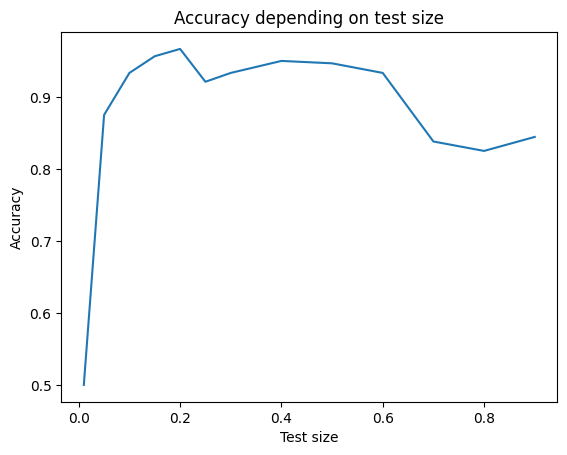

In [7]:
size = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy = calculate_accuracy_for_sizes(size)
plt.plot(size, accuracy)
plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on test size')
plt.show()

**Wnioski** : Zwiększenie rozmiaru listy, na której drzewo się uczy na samym początku rośnie w szybkim tempie i polepsza jakość decyzji podejmowanych przez drzewo. Natomiast widoczne jest, że w pewnym momencie, grupa ucząca staje się zbyt dużo, co powoduje **przetrenowanie** algorytmu i tym samym zmniejszenie jakości jego działania. Dzieje się tak, ponieważ zbytnio dostosowywuje się do modelu uczącego, bez "uogólnienia" wiedzy na nieznane przypadki, przez co z gorszą precyzją będzie klasyfikował później nieznane przypadki

W drugim badaniu sprawdzimy jaki wpływ na poprawne działanie ma głębokość drzewa, w tym celu przeprowadzimy badanie z test_size ustawionym na 0.1 oraz głębokością idącą od 1 do 8
--

In [9]:
def calculate_accuracy_for_depths(depths:list[int])-> list[float]:
    accuracy = []
    for i in range(len(depths)):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
        dc = DecisionTreeClassifier(depths[i])
        dc.start_tree(x_train, y_train)
        print(f"Accuracy: {evaluate_accuracy(dc, x_test, y_test)*100:.2f}%")
        accuracy.append(evaluate_accuracy(dc, x_test, y_test))
    return accuracy


True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 2, Predicted Class: 1
Accuracy: 60.00%
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class:

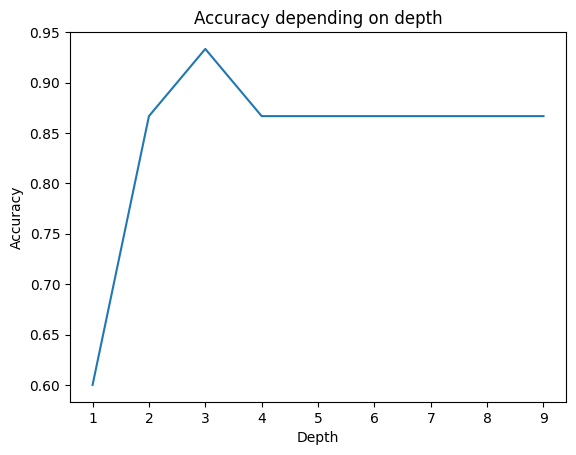

In [10]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
accuracy = calculate_accuracy_for_depths(depths)

plt.plot(depths, accuracy)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on depth')
plt.show()

**Wnioski** : W zaprezentowanym przykładzie, widzimy, że drzewo decyzyjne z dość dużą skutecznością zwraca przewidywaną klasę i największą skuteczność osiąga dla głębokości 3. Zwiększenie głębokości powoduje przetrenowanie, dlatego następuje spadke jakości działania przewidywania, który anstepnie się stabilizuje i pozostaje stały od (głębokości 4 w górę)

W trzecim badaniu porównamy różne głębokości i różne rozmiary testowe
--


In [58]:

def evaluate_accuracies_for_different_sizes_and_depths(sizes:list[float], depths:list[int]) -> list[list[float]]:
    accuracy = [[] for i in range(len(sizes))]
    for i in range(len(sizes)):
        for j in range(len(depths)):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=sizes[i], random_state=123)
            dc = DecisionTreeClassifier(depths[j])
            dc.start_tree(x_train, y_train)
            accuracy[i].append(evaluate_accuracy(dc, x_test, y_test))
    return accuracy



True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 1
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 1
True Class: 0, Predicted Class: 0
True Class: 2,

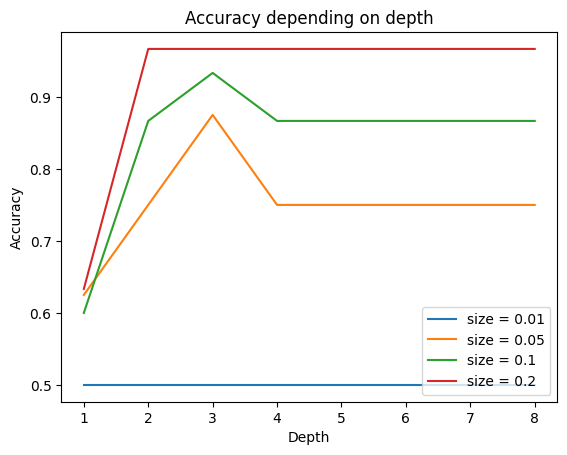

In [59]:
depths = [1, 2, 3, 4, 5, 6, 7, 8]
sizes = [0.01, 0.05, 0.1, 0.2]
accuracy = evaluate_accuracies_for_different_sizes_and_depths(sizes, depths)

plt.plot(depths, accuracy[0], label='size = 0.01')
plt.plot(depths, accuracy[1], label='size = 0.05')
plt.plot(depths, accuracy[2], label='size = 0.1')
plt.plot(depths, accuracy[3], label='size = 0.2')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on depth')
plt.legend()
plt.show()

**Wnioski** : Jak widzimy, do dla rozmiarów rzędu 0.1 i 0.05 zwiększenie głębokości polepsza jakość podejmowanych decyzji, ale przy za dużych głębokościach ochodzi do przetrenowania (skok przy głębokości 3-4 ), co powoduje spadek jakości i stabilizację na pewnym poziomie, tj. zwiększenie głębokości po tym czasie nie poprawi ani nie pogorszy działania algorytmu
Dla dużego rozmiaru rzędu 0.2 była duża gruba kwaitów do uczenia się, dlatego algorytm szybko osiągnął duże wartości skuteczności i utrzymał ten poziom do końca

W czwartm badaniu sprawdzimy jak algorytm przewiduje wartości dla losowych wartości random_seed. W tym celu ustalimy wartość na None i zoabczymy jak to wygląda
--

In [69]:
def calculate_accuracy_for_random_seeds(depth: int, amount: int) -> list[float]:
    accuracy = []
    for i in range(amount):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=None)
        dc = DecisionTreeClassifier(depth)
        dc.start_tree(x_train, y_train)
        accuracy.append(evaluate_accuracy(dc, x_test, y_test))
    return accuracy

True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 1
True Class: 1, Predicted Class: 1
Accuracy: 100.00%
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class

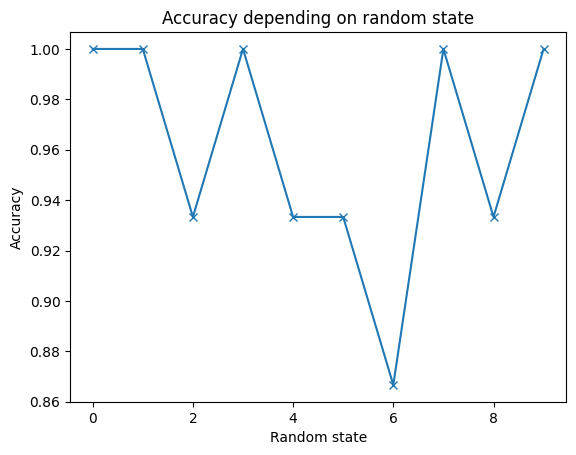

In [79]:
amount = 10
depth = 3
accuracy = calculate_accuracy_for_random_seeds(depth, amount)

plt.plot(range(amount), accuracy, marker='x')
plt.xlabel('Random state')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on random state')
plt.show()

**Wnioski** : jak widzimy w zależności od wyloswanych próbek do nauki, nasza dokładność estymacji wacha między 86 a 100 %. Zależy to głównie od próbek jakie wylosują się do szkolenia algorytmu i dla jednych wylosowanych zdąży się wyuczyć, a dla innych nie. Jednak dla głębokości 3 uzyskane wyniki i tak będą dobre
Dla porównania można zobaczyć jak zachowa się ten sam wykres dla mniejszych głębokości

True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 0, Predicted Class: 0
Accuracy: 60.00%
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 2, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 2, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class: 2
True Class: 1, Predicted Class: 2
True Class: 0, Predicted Class: 0
True Class: 1, Predicted Class:

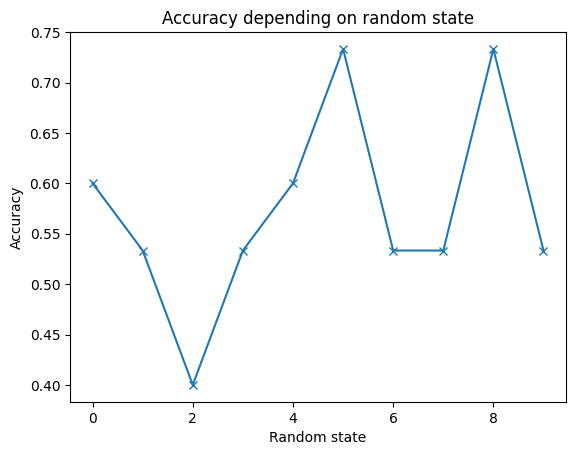

In [81]:
amount = 10
depth = 1
accuracy = calculate_accuracy_for_random_seeds(depth, amount)

plt.plot(range(amount), accuracy, marker='x')
plt.xlabel('Random state')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on random state')
plt.show()

Jak widać po zmniejszeniu głębokości do wartości 1, nasza dokładność spada do wartości między 40% a 75% i ponownie zależy to od wylosowancyh próbek do nauki

Badanie średniej dokładności
--


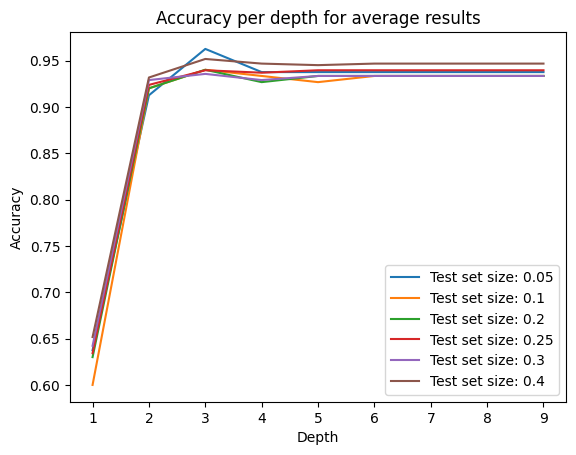

In [8]:
def get_accuracy(y_pred, y_test):
    return sum([1 if y_pred[i] == y_test[i] else 0 for i in range(len(y_pred))]) / len(y_pred)

probes = 10
fig, ax = plt.subplots()
max_depths = range(1, 10)
test_sizes = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4]


for test_size in test_sizes:
    accuracies = [0 for _ in range(len(max_depths))]
    for probe in range(probes):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=probe)
        for depth in max_depths:
            tree = DecisionTreeClassifier(depth)
            tree.start_tree(x_train, y_train)

            predictions = [tree.predict(sample) for sample in x_test]
            accuracy = get_accuracy(predictions, y_test)
            accuracies[depth - 1] += accuracy

    accuracies = [accuracy / probes for accuracy in accuracies]
    ax.plot(max_depths, accuracies, label=f"Test set size: {test_size}")

plt.title("Accuracy per depth for average results")

ax.set_xlabel("Depth")
ax.set_ylabel("Accuracy")

plt.legend()
plt.show()

Podsumowanie
==
Drzewo decyzyjne, jest dobrym sposobem używanym do klasyfikacji i z dość dużą precyzją jest w stanie poprawnie określić jakiej klasy jest dany obiekt.
Jakość przewidywań zależy od rozmiarów do nauki oraz głębokości drzewa i można zauważyć ogólną tendencję, że im większy rozmiar do nauki oraz im większa głębokość tym skuteczność jest większa.
Należy jednak pamiętać, że takie drzewo może ulec przetrenowaniu, czyli dla zbyt dużych grup do nauki i dużej głębokości, następuje spadek dokładności klasyfikowania. Ponieważ dostosuje się on do naszego modelu "na sztywno" i nie będzie otwarty na nowe, bardziej ogólne przypadki, przez co źle będzie je klasyfikował.
Z drugiej strony dla zbyt małych próbek do nauki i małych głębokości, nie zdąży się on na tyle wyuczyć, żeby z dużą dokładnością klasyfikować obiekty.
Dlatego, żeby osiągnąć jak najlepsze działanie algorytmu, to trzeba dobrze dostoswać parametry (w moim przypadku dobre wyniki były już dla głębokości 3 i rozmiaru od 0.1 do 0.2)